# Using Stability.ai API for image generation

This notebook is based on the official notebook by stability.ai:
https://github.com/Stability-AI/stability-sdk/blob/main/nbs/demo_colab.ipynb

The code is basically the same. I added mostly text to memorize better,
how the interaction with the API happens.

## Setup

- Install `stability-sdk`
- Import PIL, IPython.display.display to work with images
- Additionally, import `io` to convert binary stream to an image
- Import `getpass` and `os` which are used to set environment variables
  for authentication with the API server
  (the STABILITY_HOST variable is not that important,
  actually, as the host by default is already set to this value)

In [1]:
%pip install stability-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 2.9 MB/s eta 0:00:00
  Using cached Pillow-9.5.0-cp310-cp310-macosx_11_0_arm64.whl (3.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 7.6 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 7.7 MB/s eta 0:00:00a 0:00:01m
  Using cached python_dotenv-1.0.0-py3-none-any.whl (19 kB)
  Using cached param-1.13.0-py2.py3-none-any.whl (87 kB)
  Using cached protobuf-4.21.12-cp37-abi3-macosx_10_9_universal2.whl (486 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import getpass, os

In [3]:
os.environ["STABILITY_HOST"] = "grpc.stability.ai:443"
os.environ["STABILITY_KEY"] = getpass.getpass("Enter your Stability API key")

In [9]:
import io
import warnings

from IPython.display import display
from PIL import Image
from stability_sdk import client

import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation

Now we create the client object that interacts with the server:

In [6]:
stability_api = client.StabilityInference(
    host=os.environ["STABILITY_HOST"],
    key=os.environ["STABILITY_KEY"],
    verbose=True,
)

When we generate images using `generate` method, the provided answer
is a Generator.

What is not clear to me from the API:
- how `samples` > 1 interacts with the set seed? If the seed is set,
  then each image must be the same. However, the resultant images
  are completely different
- how one sets negative prompt?

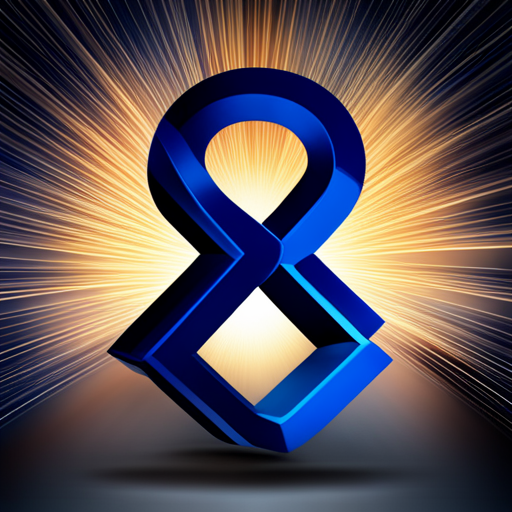

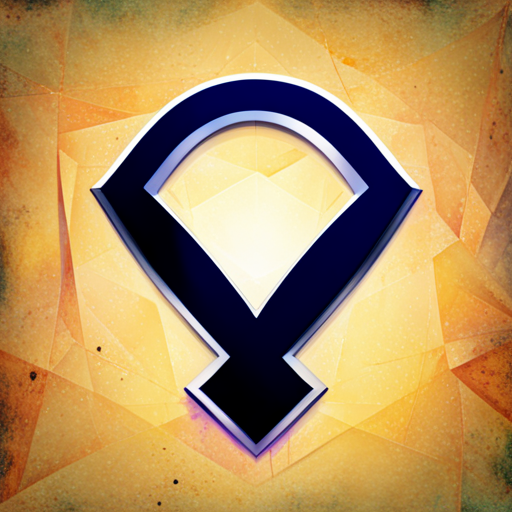

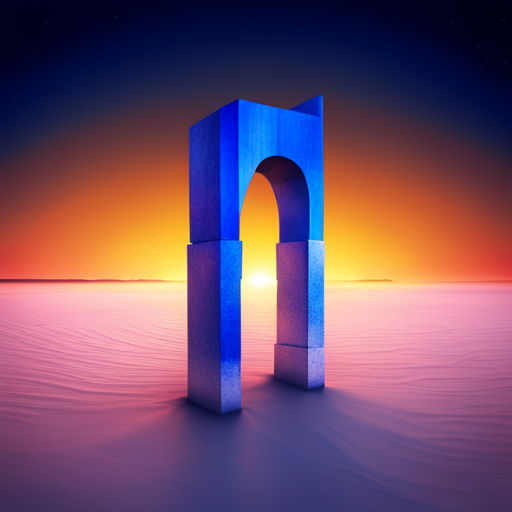

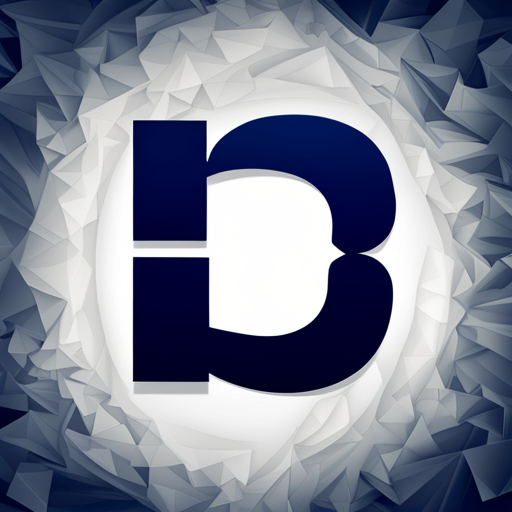

In [11]:
answers = stability_api.generate(
    prompt="Pheat, greek letter phi, 𝜑, geometric, dark blue and white colors, computer graphics",
    seed=34567,
    steps=50,
    samples=4,
)

# Iterate over the results produced by the `answers` generator.
for resp in answers: 
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated API's safety mechanism and cannot "
                "be processed. Please modify the prompt and try again"
            )
        if artifact.type == generation.ARTIFACT_IMAGE:
            img = Image.open(io.BytesIO(artifact.binary))
            display(img)

## Intermediate usage

We can use an image to initialize generation. This way we can get a variation
on what we already have.
They recommend to use a different seed in this case.
Besides, strength sets relative strength of the prompt.

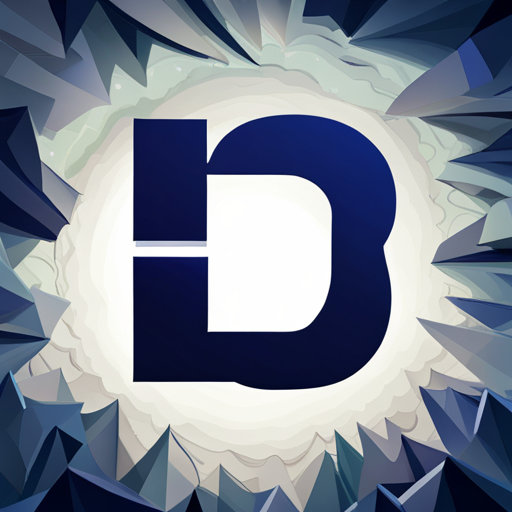

In [22]:
answers = stability_api.generate(
    prompt="Empty space in the center instead of letter D",
    init_image = img,
    seed=34568,
    start_schedule=0.6,
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your requrest did not pass through safety filter. "
                "Please modify the prompt and try again."
            )
        if artifact.type == generation.ARTIFACT_IMAGE:
            img2 = Image.open(io.BytesIO(artifact.binary))
            display(img2)

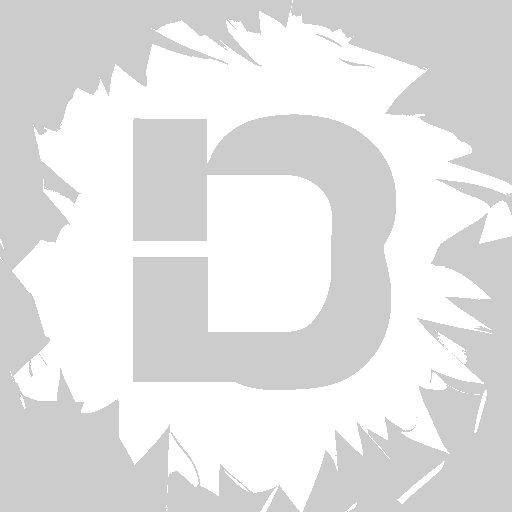

In [24]:


# we can make a rough mask by thresholding the grayscaled image

import numpy as np

img2_grayscale = img2.convert('L')
img2_a = np.array(img2_grayscale)

mask = np.array(img2_grayscale)
mask[img2_a<150] = 0  # this is the area that will get painted, will show up black below
mask[img2_a>=150] = 1 # this is the protected area, will show up white below

strength = .2  # this controls the "strength" of the prompt relative to the init image

d = int(255 * (1-strength))
mask *= 255-d # convert from range [0,1] to [0,255]
mask += d

mask = Image.fromarray(mask)
mask

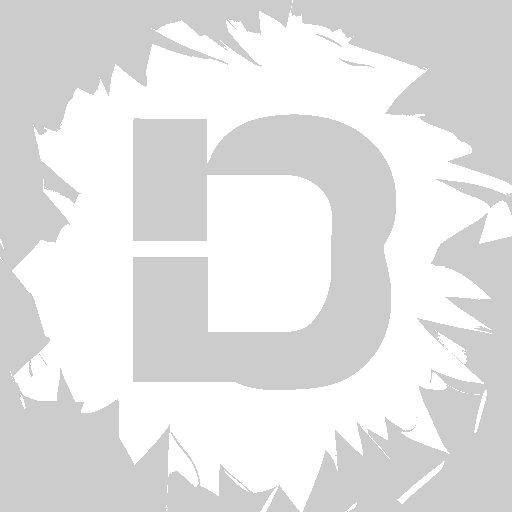

In [26]:
# fuzzing the mask edges generally improves synthesis results
from torchvision.transforms import GaussianBlur

blur = GaussianBlur(11,20)
mask

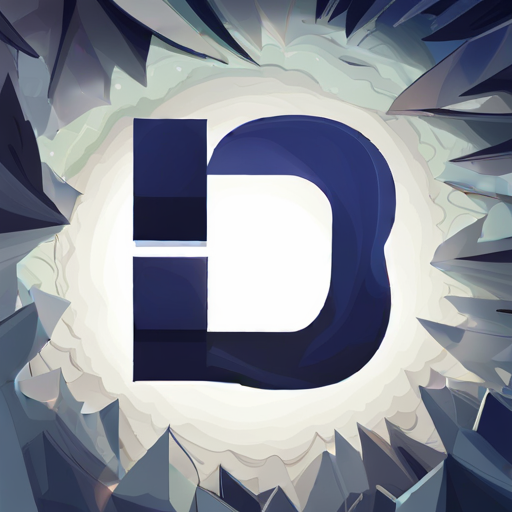

In [27]:
# now, let's send our drawing into space
answers = stability_api.generate(
    prompt="beautiful galaxies and stars in hubble telescope deep field",
    init_image=img2,
    mask_image=mask,
    seed=12345, # if we're passing in an image generated by SD, you may get better results by providing a different seed value than was used to generate the image
    start_schedule=1,
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img3 = Image.open(io.BytesIO(artifact.binary))
            display(img3)

GUIDANCE: FAST-BLUE:


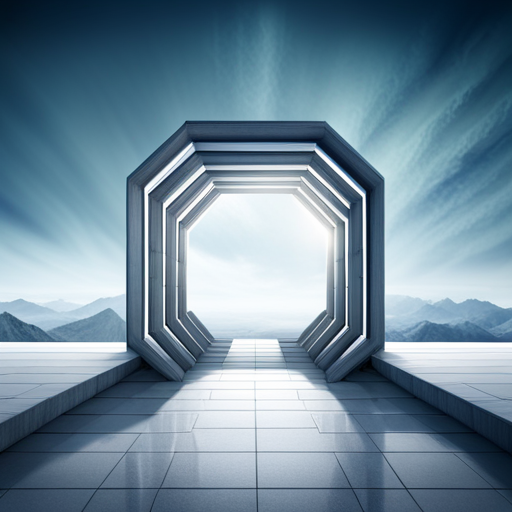

GUIDANCE: SLOWER:


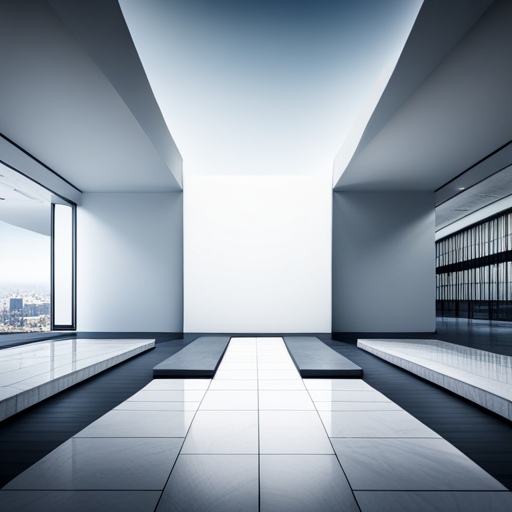

In [38]:
# we can improve our image result by introducing clip guidance into the request.
# this takes longer (and costs more compute) but often yields better results.
# clip guidance is built with several presets optimized for speed or quality,
# but clip can be controlled more precisely with a variety of other params

answers = stability_api.generate(
    prompt="Empty space in the center",
    init_image=img3,
    seed=34568,  
    steps=50, # minimum of 35 steps recommended when using CLIP
    guidance_preset=generation.GUIDANCE_PRESET_FAST_BLUE
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img4 = Image.open(io.BytesIO(artifact.binary))
            print('GUIDANCE: FAST-BLUE:')
            display(img4)

answers = stability_api.generate(
    prompt="Empty white space in the center",
    init_image=img3,
    seed=34568, 
    steps=50, 
    guidance_preset=generation.GUIDANCE_PRESET_SLOWER
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img5 = Image.open(io.BytesIO(artifact.binary))
            print('GUIDANCE: SLOWER:')
            display(img5)

I did not quite understand about CLIP guidance yet, it requires further reading.